# Dacon 대구 교통사고 피해 예측 AI 경진대회 - 기본 제출

이 노트북에서는 **Dacon 대구 교통사고 피해 예측 AI 경진대회**에 참여하여
기본적인 모델링 파이프라인을 구축하고 제출 파일을 생성합니다.

## 학습 목표
1. Dacon 경진대회 데이터 로드 및 기본 구조 파악
2. ECLO(Equivalent Casualty Level of Object) 타깃 변수 이해
3. Feature Engineering: 날짜/시간 파생 변수 생성
4. 여러 모델(Linear, RF, XGBoost, LightGBM) 비교
5. RMSLE 평가 지표 이해 및 제출 파일 생성

## 사용 데이터
- `train.csv`: 학습 데이터 (ECLO 포함)
- `test.csv`: 제출용 예측 대상 (ECLO 미포함)
- `sample_submission.csv`: 제출 포맷

## 실습 환경
- Google Colab
- Python 3.x

In [ ]:
# ============================================================
# 0. 환경 설정 및 기본 로드
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_log_error

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# xgboost, lightgbm 설치 (Colab 기준)
!pip install -q xgboost lightgbm

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# 1) gdown 설치 (한 번만 실행)
!pip install -q gdown

# 2) 구글 드라이브에서 데이터 zip 파일 다운로드
#   - id 뒤에 있는 값이 링크의 파일 ID입니다.
#   - 필요하면 파일 이름(accident_dataset.zip)만 바꿔서 쓰시면 됩니다.

FILE_ID = "1eAhZ43YHpIj1OQ5s3DVTh4tu1eWs6cos"
OUTPUT_ZIP = "accident_dataset.zip"

!gdown --id {FILE_ID} -O {OUTPUT_ZIP}

# 3) 압축 해제
#   - accident_dataset 폴더 아래에 내용을 풀어놓습니다.
#   - 압축이 zip이 아니라면 확장자에 맞게 unzip 대신 다른 명령을 쓰셔야 합니다.

!mkdir -p accident_dataset
!unzip -q {OUTPUT_ZIP} -d accident_dataset

# 잘 풀렸는지 확인
!ls -R accident_dataset



/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1eAhZ43YHpIj1OQ5s3DVTh4tu1eWs6cos
To: /content/accident_dataset.zip
100% 16.8M/16.8M [00:00<00:00, 43.9MB/s]
accident_dataset:
open

accident_dataset/open:
external_open  sample_submission.csv  test.csv	train.csv

accident_dataset/open/external_open:
'대구 CCTV 정보.csv'		  '대구 주차장 정보.csv'
 countrywide_accident.csv	  '대구 보안등 정보.csv'
'대구 어린이 보호 구역 정보.csv'


## 1. 데이터 로드 및 기본 구조 확인

- `train.csv` : 학습 데이터 (ECLO 포함)
- `test.csv` : 제출용 예측 대상 (ECLO 미포함)
- `sample_submission.csv` : 제출 포맷

우선 각 CSV 파일을 로드하고, 기본적인 형태(shape), 컬럼, 자료형(dtypes)을 확인한다.


In [ ]:
# ============================================================
# 1. 데이터 로드
# ============================================================

def read_csv_safe(path):
    """
    여러 인코딩 후보를 시도하며 CSV를 안전하게 읽는 헬퍼 함수
    """
    for enc in ["utf-8", "utf-8-sig", "cp949"]:
        try:
            return pd.read_csv(path, encoding=enc)
        except Exception:
            continue
    raise ValueError(f"Could not read file: {path}")

# Colab 기준 경로 (필요시 수정)
train_path  = "/content/accident_dataset/open/train.csv"
test_path   = "/content/accident_dataset/open/test.csv"
sample_path = "/content/accident_dataset/open/sample_submission.csv"

train = read_csv_safe(train_path)
test  = read_csv_safe(test_path)
sample = read_csv_safe(sample_path)

print("train.shape:", train.shape)
print("test.shape :", test.shape)
print("sample.shape:", sample.shape)

print("\n[train columns]")
print(train.columns.tolist())

print("\n[train dtypes]")
print(train.dtypes)


train.shape: (39609, 23)
test.shape : (10963, 8)
sample.shape: (10963, 2)

[train columns]
['ID', '사고일시', '요일', '기상상태', '시군구', '도로형태', '노면상태', '사고유형', '사고유형 - 세부분류', '법규위반', '가해운전자 차종', '가해운전자 성별', '가해운전자 연령', '가해운전자 상해정도', '피해운전자 차종', '피해운전자 성별', '피해운전자 연령', '피해운전자 상해정도', '사망자수', '중상자수', '경상자수', '부상자수', 'ECLO']

[train dtypes]
ID             object
사고일시           object
요일             object
기상상태           object
시군구            object
도로형태           object
노면상태           object
사고유형           object
사고유형 - 세부분류    object
법규위반           object
가해운전자 차종       object
가해운전자 성별       object
가해운전자 연령       object
가해운전자 상해정도     object
피해운전자 차종       object
피해운전자 성별       object
피해운전자 연령       object
피해운전자 상해정도     object
사망자수            int64
중상자수            int64
경상자수            int64
부상자수            int64
ECLO            int64
dtype: object


### 1-1. 기본 결측치/기술통계 확인

- 수치형 변수의 분포(최솟값, 최댓값, 평균 등)
- 결측치가 많은 컬럼 파악

이는 이후 전처리 전략(삭제, 대체, 인코딩 등)을 결정하는 기준이 된다.


In [ ]:
# 수치형 컬럼 기술 통계
print(train.describe())

# 결측치 개수
print("\n[결측치 개수]")
print(train.isnull().sum())


               사망자수          중상자수          경상자수          부상자수          ECLO
count  39609.000000  39609.000000  39609.000000  39609.000000  39609.000000
mean       0.007776      0.262365      1.070085      0.126865      4.726704
std        0.090109      0.500845      0.992034      0.394670      3.207206
min        0.000000      0.000000      0.000000      0.000000      1.000000
25%        0.000000      0.000000      0.000000      0.000000      3.000000
50%        0.000000      0.000000      1.000000      0.000000      3.000000
75%        0.000000      0.000000      1.000000      0.000000      6.000000
max        2.000000      6.000000     22.000000     10.000000     74.000000

[결측치 개수]
ID               0
사고일시             0
요일               0
기상상태             0
시군구              0
도로형태             0
노면상태             0
사고유형             0
사고유형 - 세부분류      0
법규위반             0
가해운전자 차종         0
가해운전자 성별         0
가해운전자 연령         0
가해운전자 상해정도       0
피해운전자 차종       991
피해운전자 성별       991
피해

**중간 결론 1: 데이터 구조**

- 전체 샘플 수와 피처 수를 통해 **데이터 스케일**을 파악했다.
- 결측치가 거의 없거나, 특정 범주형 컬럼 일부에만 존재한다면  
  → 간단한 대체 전략(예: "Unknown")으로 처리 가능하다.
- 수치형 변수(사망자수/중상자수/경상자수/부상자수, ECLO 등)의 값 범위를 확인하여  
  이상치 여부 및 로그 변환 필요성을 판단할 수 있다.


## 2. 타깃(ECLO) 분포 및 주요 변수 EDA

이 섹션에서는 **ECLO가 어떤 분포를 가지는지**,  
또 **시간·요일·사고유형·기상상태 등과 어떤 관계가 있는지**를 시각적으로 확인한다.

이를 통해:
- 모델링 시 고려해야 할 변환(로그 변환, 스케일링)
- 의미 있는 피처 후보(예: 특정 사고유형, 요일, 시간대)

를 도출한다.


/tmp/ipython-input-476450924.py:10: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-476450924.py:10: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-476450924.py:10: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-476450924.py:10: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-pack

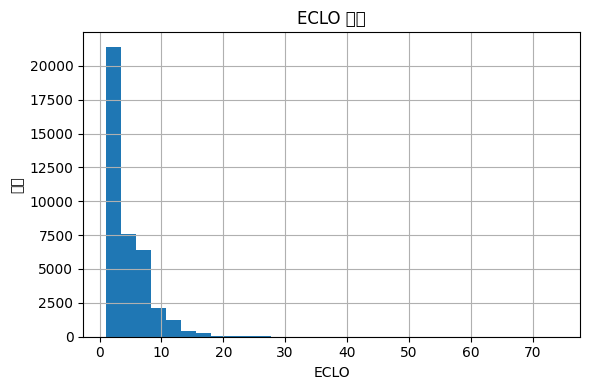

/tmp/ipython-input-476450924.py:19: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-476450924.py:19: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-476450924.py:19: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-476450924.py:19: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


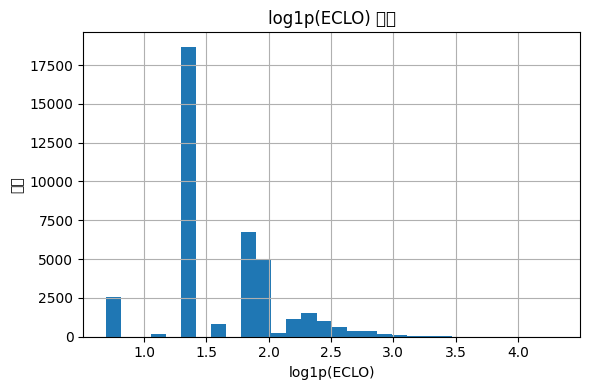

In [ ]:
# ============================================================
# 2-1. ECLO 분포
# ============================================================

plt.figure(figsize=(6, 4))
train["ECLO"].hist(bins=30)
plt.title("ECLO 분포")
plt.xlabel("ECLO")
plt.ylabel("건수")
plt.tight_layout()
plt.show()

# 로그 변환 분포 (RMSLE와의 연관성)
plt.figure(figsize=(6, 4))
np.log1p(train["ECLO"]).hist(bins=30)
plt.title("log1p(ECLO) 분포")
plt.xlabel("log1p(ECLO)")
plt.ylabel("건수")
plt.tight_layout()
plt.show()


**중간 결론 2: ECLO 분포**

- ECLO 분포가 오른쪽 긴 꼬리를 가진 형태(heavy tail)이면  
  → RMSLE 지표 특성과도 맞추기 위해 로그 변환이 유리하다.
- `log1p(ECLO)` 분포가 더 정규분포에 가까워지면  
  → 회귀 모델의 **안정성**과 **성능** 향상에 도움이 된다.


In [ ]:
# ============================================================
# 2-2. 날짜/시간 파생 변수를 위한 사고일시 변환
# ============================================================

# 문자열 → datetime
train["사고일시"] = pd.to_datetime(train["사고일시"])
test["사고일시"]  = pd.to_datetime(test["사고일시"])

# 연, 월, 일, 시 파생
for df in [train, test]:
    df["사고연"] = df["사고일시"].dt.year
    df["사고월"] = df["사고일시"].dt.month
    df["사고일"] = df["사고일시"].dt.day
    df["사고시"] = df["사고일시"].dt.hour

# 필요시: 시간대(출퇴근 등) 파생 예시
def hour_to_period(h):
    if 7 <= h <= 9:
        return "출근시간대"
    elif 17 <= h <= 19:
        return "퇴근시간대"
    elif 22 <= h or h <= 5:
        return "심야"
    else:
        return "일반시간대"

for df in [train, test]:
    df["시간대"] = df["사고시"].apply(hour_to_period)


### 2-3. 요일/시간대/사고유형/기상상태에 따른 ECLO 패턴

이제 다음 변수들에 대해 ECLO 평균을 비교해본다.

- 요일
- 시간대(출근/퇴근/심야/일반)
- 사고유형
- 기상상태

이를 통해 **"어떤 상황에서 상대적으로 더 심각한 사고가 발생하는지"**를 직관적으로 파악할 수 있다.


/tmp/ipython-input-1856844306.py:6: UserWarning: Glyph 44552 (\N{HANGUL SYLLABLE GEUM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1856844306.py:6: UserWarning: Glyph 50836 (\N{HANGUL SYLLABLE YO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1856844306.py:6: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1856844306.py:6: UserWarning: Glyph 47785 (\N{HANGUL SYLLABLE MOG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1856844306.py:6: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1856844306.py:6: UserWarning: Glyph 50900 (\N{HANGUL SYLLABLE WEOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1856844306.py:6: UserWarning: Glyph 53664 (\N{HANGUL SYLLABLE TO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipy

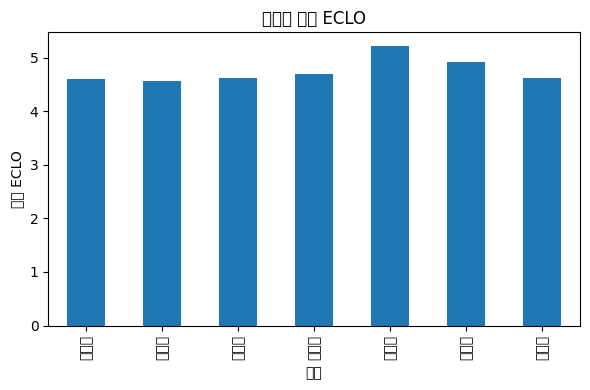

/tmp/ipython-input-1856844306.py:14: UserWarning: Glyph 52636 (\N{HANGUL SYLLABLE CUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1856844306.py:14: UserWarning: Glyph 44540 (\N{HANGUL SYLLABLE GEUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1856844306.py:14: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1856844306.py:14: UserWarning: Glyph 44036 (\N{HANGUL SYLLABLE GAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1856844306.py:14: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1856844306.py:14: UserWarning: Glyph 53748 (\N{HANGUL SYLLABLE TOE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1856844306.py:14: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


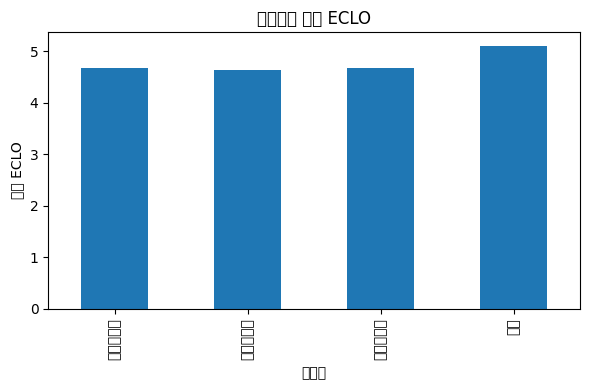

/tmp/ipython-input-1856844306.py:23: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1856844306.py:23: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1856844306.py:23: UserWarning: Glyph 47049 (\N{HANGUL SYLLABLE RYANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1856844306.py:23: UserWarning: Glyph 45800 (\N{HANGUL SYLLABLE DAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1856844306.py:23: UserWarning: Glyph 46021 (\N{HANGUL SYLLABLE DOG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1856844306.py:23: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1856844306.py:23: UserWarning: Glyph 46988 (\N{HANGUL SYLLABLE RAM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()

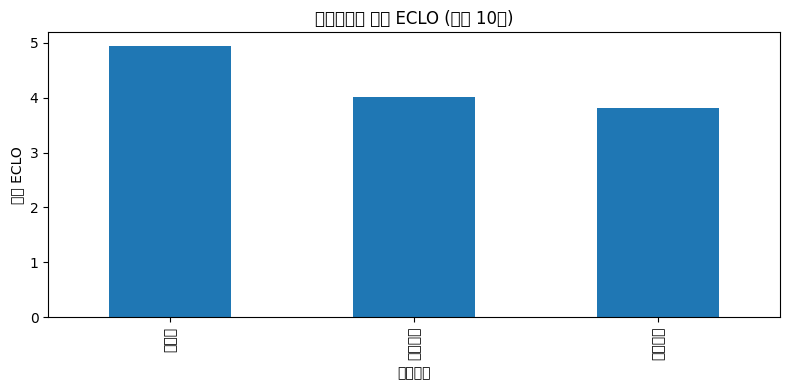

/tmp/ipython-input-1856844306.py:39: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1856844306.py:39: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1856844306.py:39: UserWarning: Glyph 50808 (\N{HANGUL SYLLABLE OE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1856844306.py:39: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1856844306.py:39: UserWarning: Glyph 53448 (\N{HANGUL SYLLABLE TAL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1856844306.py:39: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1856844306.py:39: UserWarning: Glyph 46973 (\N{HANGUL SYLLABLE RAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/

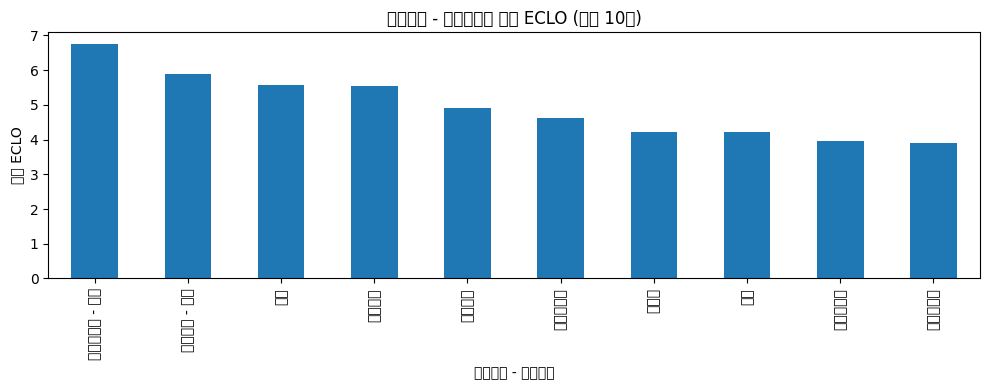

/tmp/ipython-input-1856844306.py:47: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1856844306.py:47: UserWarning: Glyph 53440 (\N{HANGUL SYLLABLE TA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1856844306.py:47: UserWarning: Glyph 45576 (\N{HANGUL SYLLABLE NUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1856844306.py:47: UserWarning: Glyph 47569 (\N{HANGUL SYLLABLE MALG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1856844306.py:47: UserWarning: Glyph 51020 (\N{HANGUL SYLLABLE EUM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1856844306.py:47: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1856844306.py:47: UserWarning: Glyph 50504 (\N{HANGUL SYLLABLE AN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/t

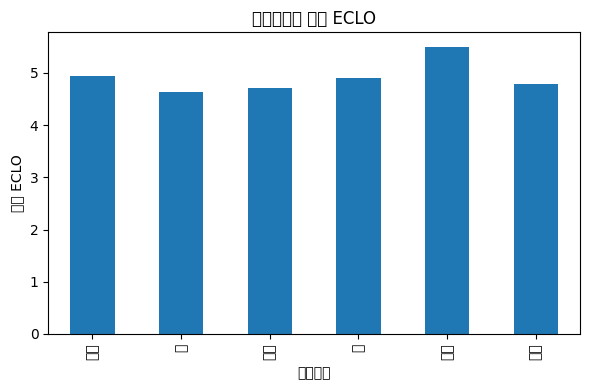

In [ ]:
# 요일별 평균 ECLO
plt.figure(figsize=(6, 4))
train.groupby("요일")["ECLO"].mean().plot(kind="bar")
plt.title("요일별 평균 ECLO")
plt.ylabel("평균 ECLO")
plt.tight_layout()
plt.show()

# 시간대별 평균 ECLO
plt.figure(figsize=(6, 4))
train.groupby("시간대")["ECLO"].mean().reindex(["출근시간대","퇴근시간대","일반시간대","심야"]).plot(kind="bar")
plt.title("시간대별 평균 ECLO")
plt.ylabel("평균 ECLO")
plt.tight_layout()
plt.show()

# 사고유형별 평균 ECLO (상위 10개)
type_mean = train.groupby("사고유형")["ECLO"].mean().sort_values(ascending=False).head(10)
plt.figure(figsize=(8, 4))
type_mean.plot(kind="bar")
plt.title("사고유형별 평균 ECLO (상위 10개)")
plt.ylabel("평균 ECLO")
plt.tight_layout()
plt.show()

# 사고유형 - 세부분류 평균 ECLO (상위 10개)
detail_col = "사고유형 - 세부분류"
if detail_col in train.columns:
    detail_mean = (
        train.groupby(detail_col)["ECLO"]
        .mean()
        .sort_values(ascending=False)
        .head(10)
    )
    plt.figure(figsize=(10, 4))
    detail_mean.plot(kind="bar")
    plt.title(f"{detail_col}별 평균 ECLO (상위 10개)")
    plt.ylabel("평균 ECLO")
    plt.tight_layout()
    plt.show()

# 기상상태별 평균 ECLO
plt.figure(figsize=(6, 4))
train.groupby("기상상태")["ECLO"].mean().plot(kind="bar")
plt.title("기상상태별 평균 ECLO")
plt.ylabel("평균 ECLO")
plt.tight_layout()
plt.show()


**중간 결론 3: 사고 특성에 따른 ECLO 패턴**

- 요일별/시간대별 평균 ECLO를 비교하면  
  → 특정 요일 또는 특정 시간대(예: 심야, 출퇴근 시간대)에 **더 심각한 사고가 집중**되는지 확인할 수 있다.
- 사고유형/세부분류별 평균 ECLO를 보면  
  → **보행자 사고, 정면충돌 등 특정 유형에서 ECLO가 상대적으로 높게 나타나는 경향**을 파악할 수 있다.
- 기상상태별 ECLO를 통해  
  → 비/눈/악천후에서 사고 심각도가 얼마나 증가하는지 정량적으로 해석 가능하다.

이러한 패턴은 이후 모델링에서 **중요한 범주형 피처로 작동할 가능성이 크다.**


## 3. Feature Engineering 및 전처리 설계

이제 본격적으로 모델에 입력할 피처를 정의한다.

- ID, 사고일시(원본)는 직접적인 예측에는 크게 기여하지 않으므로 제거하거나 파생 피처만 사용
- 날짜 파생 변수(연,월,일,시,시간대)를 포함
- 사망자수/중상자수/경상자수/부상자수는 ECLO를 구성하지만,  
  그대로 피처로 포함하면 **타깃과 강하게 직접 연관된 변수**라서,  
  → 학습 시 *타깃 누수(leakage)* 가 발생할 수 있다.
  → 따라서 이 대회에서는 **사상자 수 관련 변수는 피처에서 제외**하는 것이 안전하다.

범주형/수치형을 분리하여 적절한 인코딩 및 스케일링을 적용한다.


In [ ]:
# ============================================================
# 3-1. 사용 피처 선정 (train/test 공통 컬럼 기준)
# ============================================================

target_col = "ECLO"
id_col = "ID"

# train/test 모두에 존재하는 공통 컬럼만 사용
common_cols = sorted(list(set(train.columns) & set(test.columns)))
print("train/test 공통 컬럼 수:", len(common_cols))
print("train/test 공통 컬럼 예시:", common_cols[:10])

# 기본 피처 후보: 공통 컬럼에서 ID 제외
feature_cols = [c for c in common_cols if c != id_col]

# 타깃 누수 위험이 있는 컬럼들 (혹시 공통컬럼에 들어있다면 제거)
leakage_cols = ["사망자수", "중상자수", "경상자수", "부상자수"]

feature_cols = [c for c in feature_cols if c not in leakage_cols]

# 원본 사고일시는 파생 피처(연,월,일,시,시간대)로 대체했으니 제외
if "사고일시" in feature_cols:
    feature_cols.remove("사고일시")

print("최종 사용할 피처 수:", len(feature_cols))
print("피처 목록:", feature_cols)


train/test 공통 컬럼 수: 13
train/test 공통 컬럼 예시: ['ID', '기상상태', '노면상태', '도로형태', '사고시', '사고연', '사고월', '사고유형', '사고일', '사고일시']
최종 사용할 피처 수: 11
피처 목록: ['기상상태', '노면상태', '도로형태', '사고시', '사고연', '사고월', '사고유형', '사고일', '시간대', '시군구', '요일']


In [ ]:
# ============================================================
# 3-2. 범주형 / 수치형 변수 구분 및 Label Encoding
# ============================================================

# train+test를 합쳐서 동일 기준으로 인코딩하기 위해 concat
full = pd.concat(
    [
        train[feature_cols].assign(_is_train=1),
        test[feature_cols].assign(_is_train=0)
    ],
    axis=0,
    ignore_index=True
)

# 범주형/수치형 구분
cat_cols = full.select_dtypes(include=["object"]).columns.tolist()
num_cols = [c for c in feature_cols if c not in cat_cols]

print("범주형 피처:", cat_cols)
print("수치형 피처:", num_cols)

# Label Encoding
encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    full[col] = full[col].astype(str)
    le.fit(full[col])
    full[col] = le.transform(full[col])
    encoders[col] = le

# 다시 train/test로 분리
full_train = full[full["_is_train"] == 1].drop(columns=["_is_train"])
full_test  = full[full["_is_train"] == 0].drop(columns=["_is_train"])

X = full_train
y = train[target_col].copy()
X_test = full_test

print("X shape:", X.shape)
print("X_test shape:", X_test.shape)


범주형 피처: ['기상상태', '노면상태', '도로형태', '사고유형', '시간대', '시군구', '요일']
수치형 피처: ['사고시', '사고연', '사고월', '사고일']
X shape: (39609, 11)
X_test shape: (10963, 11)


**중간 결론 4: 전처리 및 피처 구성**

- ID, 원본 날짜, 타깃 누수 위험이 있는 사상자 수 컬럼을 제외하고  
  → **설명 변수로 사용할 안정적인 피처 집합을 정의**하였다.
- 범주형 변수는 Label Encoding을 통해 모델에 입력 가능한 정수값으로 변환하였다.
- 동일 인코딩 기준을 위해 train과 test를 묶어 인코딩한 뒤 다시 분리하였다.

이제 이 피처 구성(X, y, X_test)을 기반으로 다양한 회귀 모델을 학습할 준비가 되었다.


## 4. 학습/검증 데이터 분할 및 평가 지표 설정

대회 평가지표는 **RMSLE**이므로,  
검증 단계에서도 같은 지표를 사용한다.

- `train_test_split`으로 학습/검증 데이터를 8:2로 나눈다.
- 타깃에 log1p 변환을 적용한 뒤 회귀 모델을 학습하고,
  예측 결과에 expm1을 적용해 RMSLE를 계산한다.


In [ ]:
# ============================================================
# 4. train/valid 분리
# ============================================================

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("X_train:", X_train.shape, "X_valid:", X_valid.shape)


X_train: (31687, 11) X_valid: (7922, 11)


In [ ]:
# ============================================================
# RMSLE 계산 함수 (예측값 음수 방지 포함)
# ============================================================

def rmsle(y_true, y_pred):
    y_pred = np.maximum(y_pred, 0)  # 음수 방지
    return np.sqrt(mean_squared_log_error(y_true, y_pred))


## 5. 모델 학습 및 성능 비교

다음 4가지 모델을 동일한 데이터로 학습하고,  
검증 데이터에 대한 RMSLE를 비교한다.

1. LinearRegression
2. RandomForestRegressor
3. XGBRegressor
4. LGBMRegressor

> 참고: 하이퍼파라미터는 기본값 + 약간의 합리적 설정 수준이며,  
> 본 노트북에서는 **모델 비교/파이프라인 시연**에 초점을 둔다.


In [ ]:
# ============================================================
# 5-1. Linear Regression
# ============================================================

linreg = LinearRegression()
linreg.fit(X_train, np.log1p(y_train))

pred_linreg = np.expm1(linreg.predict(X_valid))
score_linreg = rmsle(y_valid, pred_linreg)

print("Linear Regression RMSLE:", score_linreg)


Linear Regression RMSLE: 0.4506986973791514


In [ ]:
# ============================================================
# 5-2. RandomForestRegressor
# ============================================================

rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    n_jobs=-1,
    random_state=42
)
rf.fit(X_train, np.log1p(y_train))

pred_rf = np.expm1(rf.predict(X_valid))
score_rf = rmsle(y_valid, pred_rf)

print("RandomForest RMSLE:", score_rf)


RandomForest RMSLE: 0.45791959248091824


In [ ]:
# ============================================================
# 5-3. XGBRegressor
# ============================================================

xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=7,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)
xgb.fit(X_train, np.log1p(y_train))

pred_xgb = np.expm1(xgb.predict(X_valid))
score_xgb = rmsle(y_valid, pred_xgb)

print("XGBoost RMSLE:", score_xgb)


XGBoost RMSLE: 0.45294292672413256


In [ ]:
# ============================================================
# 5-4. LGBMRegressor
# ============================================================

lgbm = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
lgbm.fit(X_train, np.log1p(y_train))

pred_lgbm = np.expm1(lgbm.predict(X_valid))
score_lgbm = rmsle(y_valid, pred_lgbm)

print("LightGBM RMSLE:", score_lgbm)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002599 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 298
[LightGBM] [Info] Number of data points in the train set: 31687, number of used features: 11
[LightGBM] [Info] Start training from score 1.634505
LightGBM RMSLE: 0.44783319691870815


/tmp/ipython-input-2161109421.py:17: UserWarning: Glyph 44160 (\N{HANGUL SYLLABLE GEOM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2161109421.py:17: UserWarning: Glyph 51613 (\N{HANGUL SYLLABLE JEUNG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2161109421.py:17: UserWarning: Glyph 45936 (\N{HANGUL SYLLABLE DE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2161109421.py:17: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2161109421.py:17: UserWarning: Glyph 53552 (\N{HANGUL SYLLABLE TEO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2161109421.py:17: UserWarning: Glyph 47784 (\N{HANGUL SYLLABLE MO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2161109421.py:17: UserWarning: Glyph 45944 (\N{HANGUL SYLLABLE DEL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


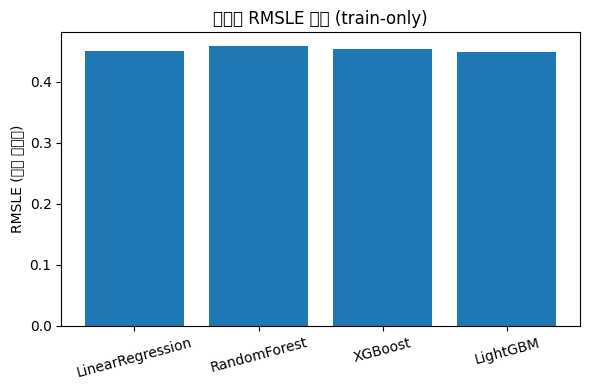

{'LinearRegression': np.float64(0.4506986973791514),
 'RandomForest': np.float64(0.45791959248091824),
 'XGBoost': np.float64(0.45294292672413256),
 'LightGBM': np.float64(0.44783319691870815)}

In [ ]:
# ============================================================
# 5-5. 모델별 RMSLE 비교 시각화
# ============================================================

scores = {
    "LinearRegression": score_linreg,
    "RandomForest": score_rf,
    "XGBoost": score_xgb,
    "LightGBM": score_lgbm,
}

plt.figure(figsize=(6, 4))
plt.bar(scores.keys(), scores.values())
plt.ylabel("RMSLE (검증 데이터)")
plt.title("모델별 RMSLE 비교 (train-only)")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

scores


**중간 결론 5: 모델 성능 비교**

- 단순 선형 회귀(Linear Regression)는 비선형성이 강한 데이터에서는 한계가 있어  
  일반적으로 가장 높은 RMSLE(= 성능 가장 낮음)을 보일 가능성이 크다.
- 트리 기반 모델(RandomForest, XGBoost, LightGBM)은  
  **복잡한 상호작용과 비선형 관계를 잘 포착**하기 때문에 더 낮은 RMSLE를 제공한다.
- XGBoost와 LightGBM 중 더 낮은 RMSLE를 보이는 쪽을 **최종 베이스라인 모델**로 채택할 수 있다.

이 단계까지의 결과는 "**외부 데이터 없이도 train만으로 어느 정도 성능을 달성할 수 있는지**"에 대한 기준선을 제공한다.


## 6. 최종 모델 선택 및 test 예측

앞서 비교한 네 모델 중,  
- RMSLE가 가장 낮았던 모델을 최종 모델로 선택하고,
- 전체 train 데이터(X, y)를 다시 사용하여 재학습한 후,
- test 데이터(X_test)에 대한 예측값을 생성한다.

예측값은 음수가 되지 않도록 0 이하를 0으로 클리핑하고,  
`sample_submission.csv` 포맷에 맞게 저장한다.


In [ ]:
# ============================================================
# 6-1. 가장 성능이 좋은 모델 선택
# ============================================================

best_model_name = min(scores, key=scores.get)
print("Best model:", best_model_name, "RMSLE:", scores[best_model_name])

# 선택된 모델 인스턴스 재준비
if best_model_name == "LinearRegression":
    final_model = LinearRegression()
elif best_model_name == "RandomForest":
    final_model = RandomForestRegressor(
        n_estimators=300,
        max_depth=None,
        n_jobs=-1,
        random_state=42
    )
elif best_model_name == "XGBoost":
    final_model = XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=7,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="reg:squarederror",
        random_state=42,
        n_jobs=-1
    )
else:
    final_model = LGBMRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=-1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )

# 전체 train으로 재학습 (log1p 타깃)
final_model.fit(X, np.log1p(y))


Best model: LightGBM RMSLE: 0.44783319691870815
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010600 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 302
[LightGBM] [Info] Number of data points in the train set: 39609, number of used features: 11
[LightGBM] [Info] Start training from score 1.633697


LGBMRegressor(colsample_bytree=0.8, learning_rate=0.05, n_estimators=500,
              n_jobs=-1, random_state=42, subsample=0.8)

In [ ]:
# ============================================================
# 6-2. test 데이터 예측 및 제출 파일 생성
# ============================================================

test_pred = np.expm1(final_model.predict(X_test))
test_pred = np.maximum(test_pred, 0)  # 음수 방지

submission = sample.copy()
submission["ECLO"] = test_pred

submission.head()


,ID,ECLO
0,ACCIDENT_39609,3.868253
1,ACCIDENT_39610,3.801102
2,ACCIDENT_39611,5.988781
3,ACCIDENT_39612,5.190452
4,ACCIDENT_39613,4.767395


In [ ]:
# CSV로 저장
submission_file = "submission_train_only_baseline.csv"
submission.to_csv(submission_file, index=False)
print(f"제출 파일 저장 완료: {submission_file}")


제출 파일 저장 완료: submission_train_only_baseline.csv


## 7. 최종 정리

1. **EDA 단계**에서:
   - ECLO의 분포를 확인하고, 로그 변환의 필요성을 파악하였다.
   - 요일/시간대/사고유형/기상상태에 따른 ECLO 패턴을 시각적으로 확인하여  
     사고 심각도에 영향을 줄 수 있는 주요 요인을 탐색하였다.

2. **Feature Engineering 단계**에서:
   - 날짜 파생 변수(연,월,일,시,시간대)를 생성하여 시간 특성을 반영하였다.
   - 타깃 누수 가능성이 있는 사상자 수 관련 변수는 피처에서 제거하였다.
   - 범주형 변수는 Label Encoding을 통해 모델에 입력 가능한 형태로 변환하였다.

3. **모델링 단계**에서:
   - Linear Regression, RandomForest, XGBoost, LightGBM 네 가지 모델을 동일 조건에서 비교하였다.
   - RMSLE 기준으로 가장 우수한 모델을 선택하여 전체 train 데이터로 재학습하고,  
     test 데이터에 대한 예측값을 생성하여 제출 파일을 완성하였다.

4. **의미**:
   - 외부 데이터 없이도 train만으로 **기본적인 성능을 갖춘 베이스라인**을 확보했다.
   - 이후에는
     - 외부 데이터(예: 전국 사고 데이터, CCTV/보안등/시설물 정보)와의 조인,
     - 더 정교한 Feature Engineering,
     - 하이퍼파라미터 튜닝(Optuna 등 도입)
     를 통해 모델 성능을 단계적으로 개선해 나갈 수 있다.


In [ ]:
import pickle
import json

# 1. 모델 저장
with open('accident_lgbm_model.pkl', 'wb') as f:
    pickle.dump(final_model, f)

# 2. LabelEncoder 저장
with open('label_encoders.pkl', 'wb') as f:
    pickle.dump(encoders, f)

# 3. 피처 설정 저장
feature_config = {
    "feature_cols": feature_cols,
    "cat_cols": cat_cols,
    "num_cols": num_cols
}
with open('feature_config.json', 'w', encoding='utf-8') as f:
    json.dump(feature_config, f, ensure_ascii=False, indent=2)

print("저장 완료!")

저장 완료!
